In [2]:
import argparse
import numpy as np
import pandas as pd
import pickle
import ast, os, sys
import neuroglancer
import matplotlib
import cv2
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

In [3]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.sqlcontroller import SqlController
from utilities.file_location import DATA_PATH, ROOT_DIR

Connecting dklab@192.168.1.12:3306


In [103]:
atlas_name = 'atlasV8'
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')

In [104]:
structure = 'SC'
filename = os.path.join(VOLUME_PATH, f'{structure}.npy')

In [105]:
volume = np.load(filename)
surface_threshold = 0.8

#volume = np.rot90(volume, axes=(0, 1))
#volume = np.flip(volume, axis=0)
#volume[volume > surface_threshold] = 18
#volume = volume.astype(np.uint8)
volume.dtype, volume.shape, np.median(volume), np.mean(volume), np.amax(volume)
#SCV8 (169, 237, 371),1.638132609477359e-08,0.19126886998493886,1.0)

(dtype('float64'),
 (169, 237, 371),
 1.638132609477359e-08,
 0.19126886998493886,
 1.0)

Text(0.5, 1.0, 'SC float')

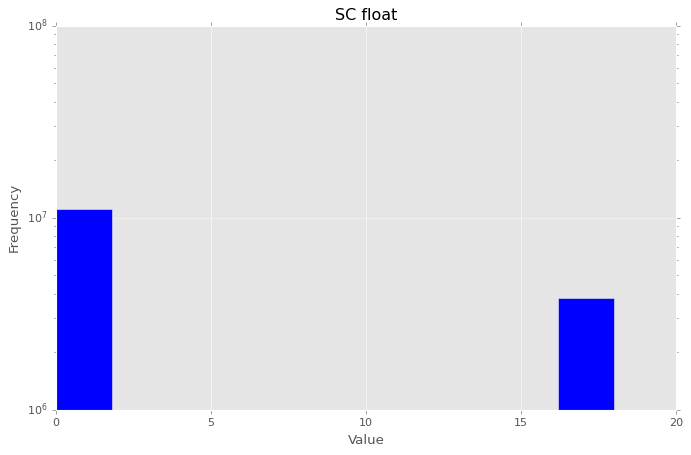

In [107]:
volume[volume > 0.09] = 18
flat = volume.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'{structure} float')

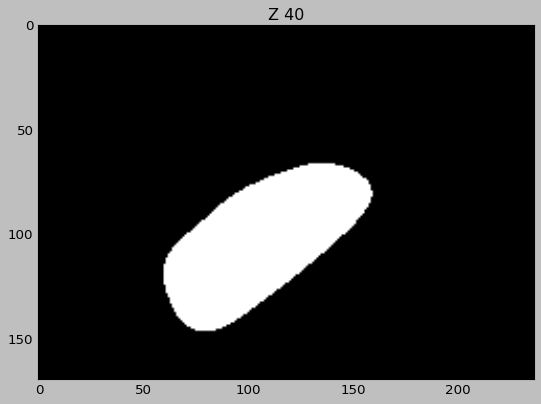

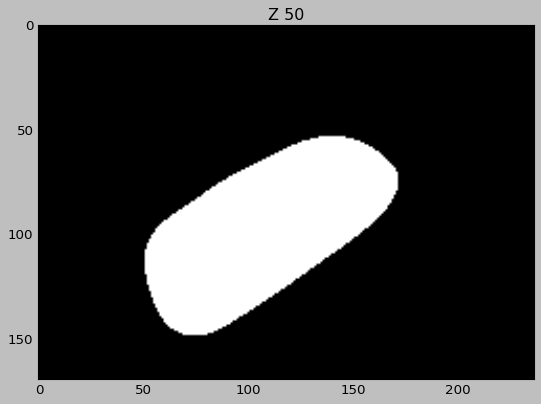

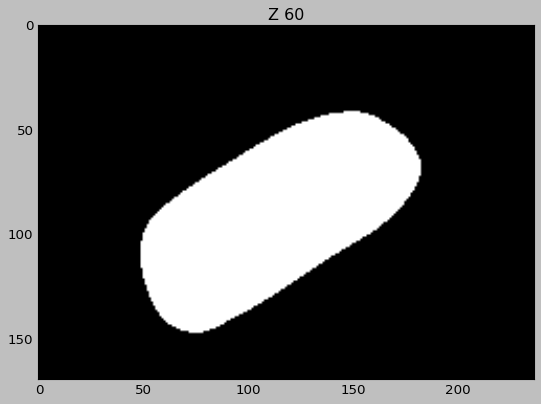

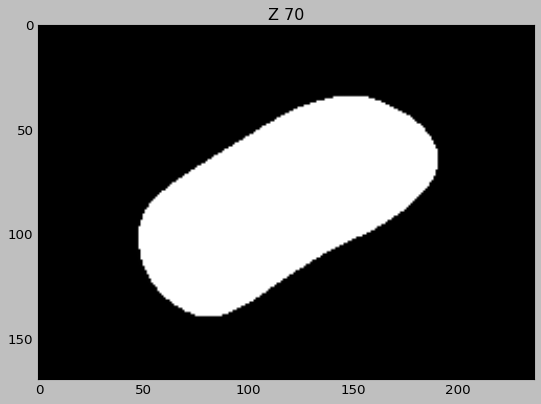

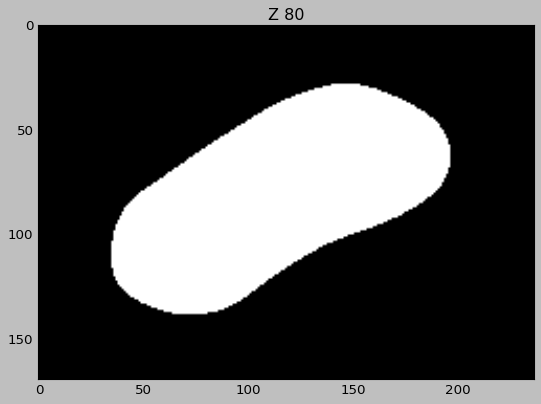

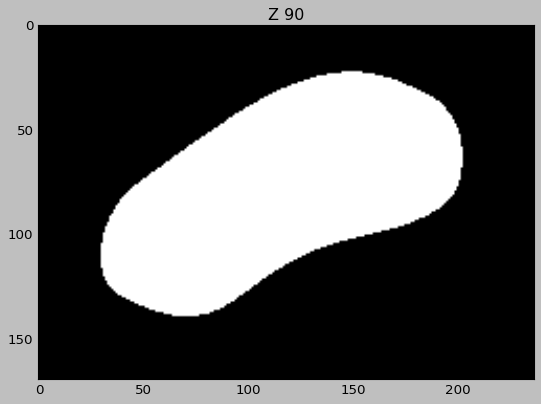

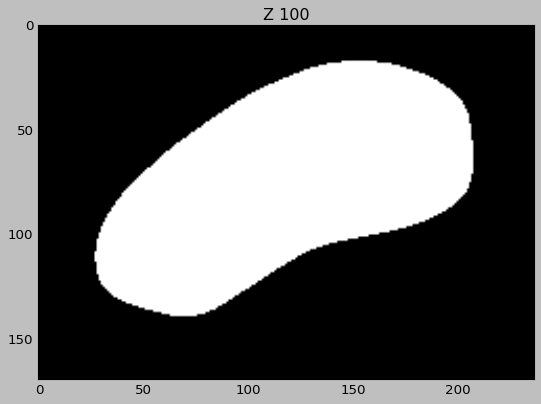

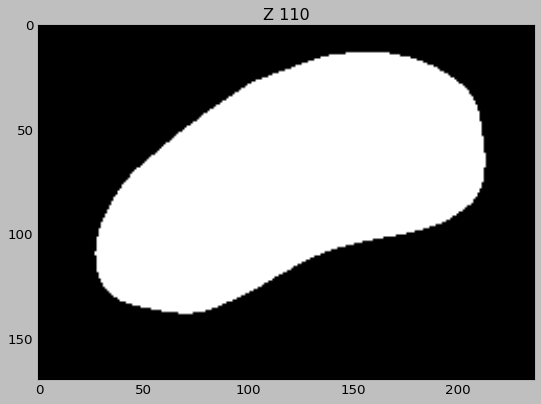

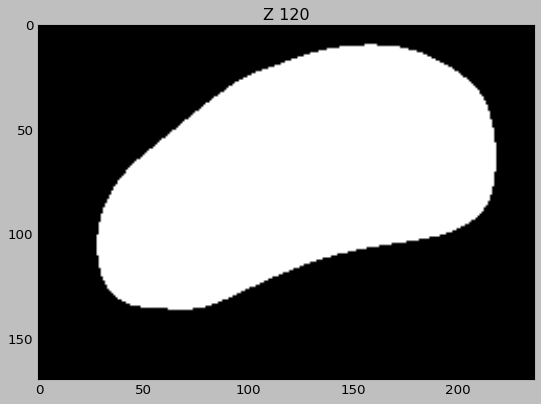

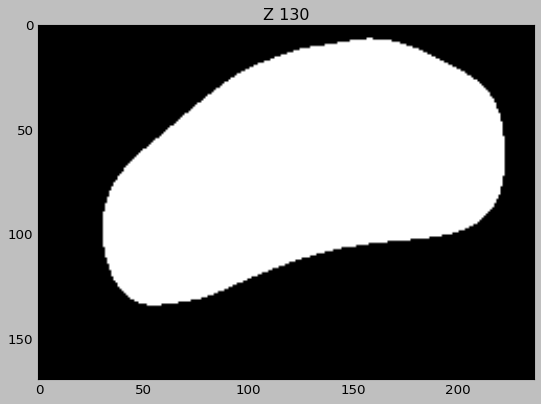

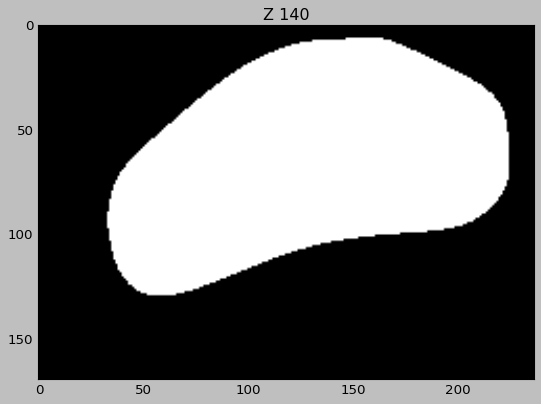

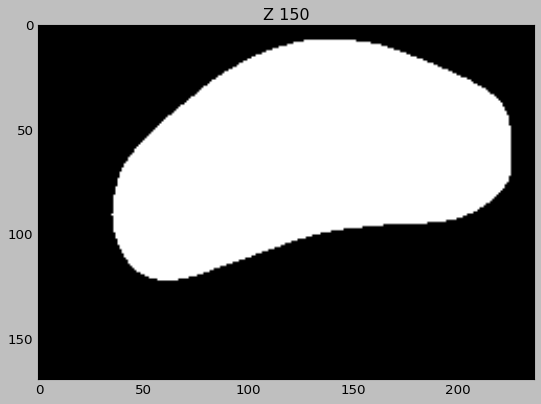

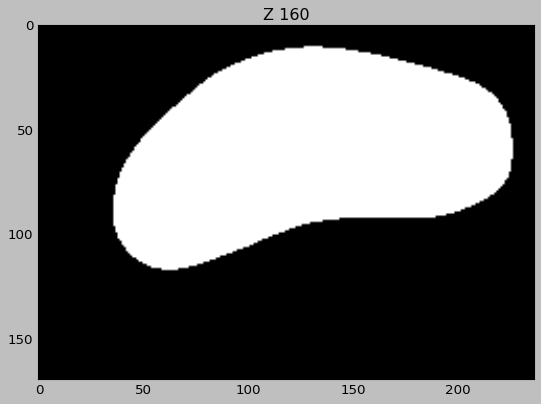

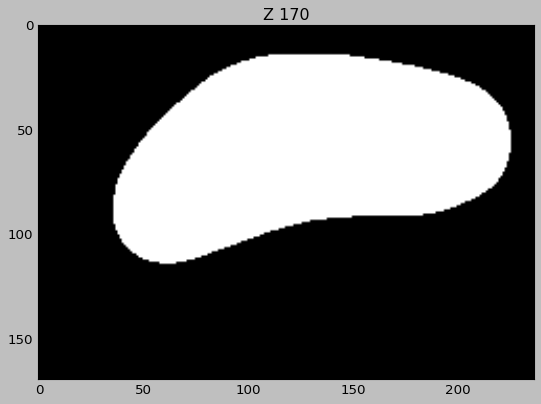

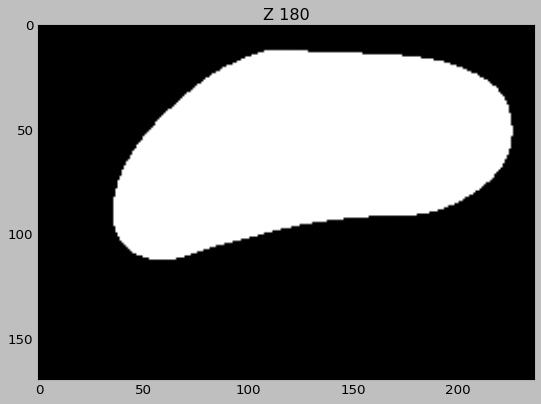

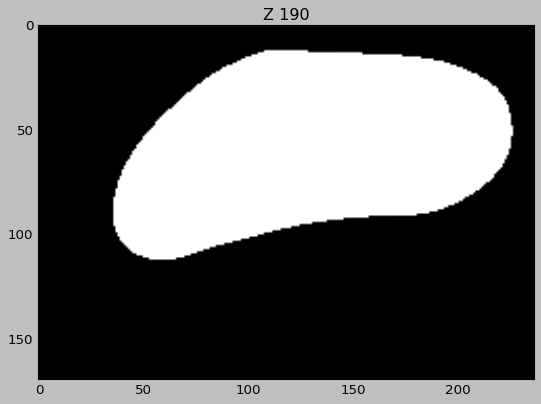

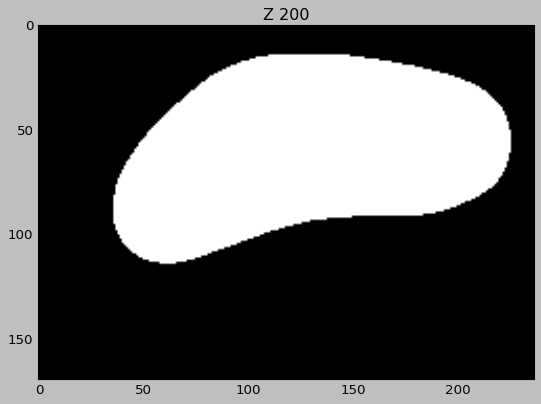

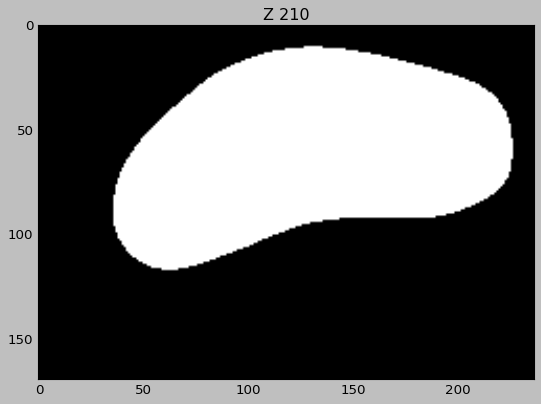

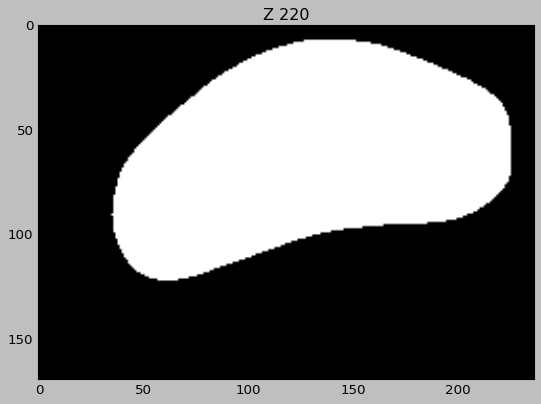

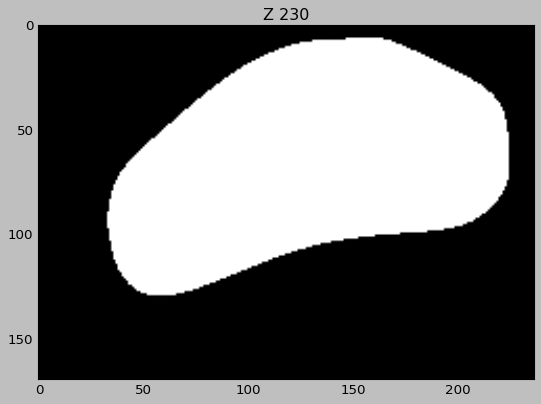

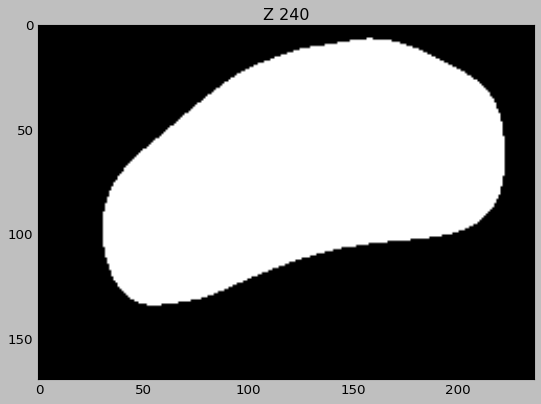

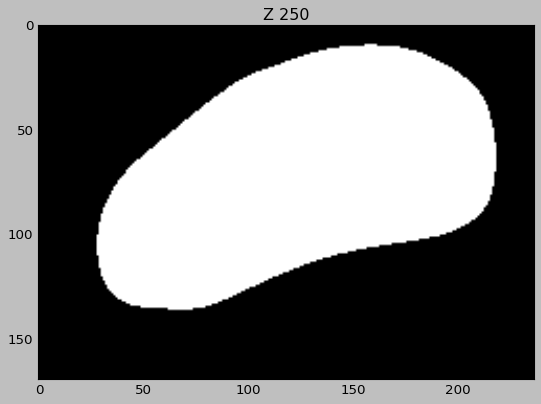

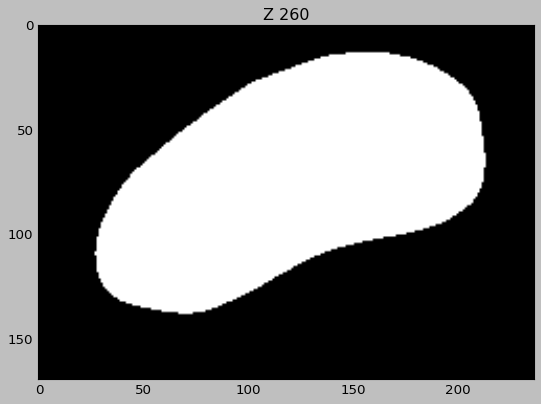

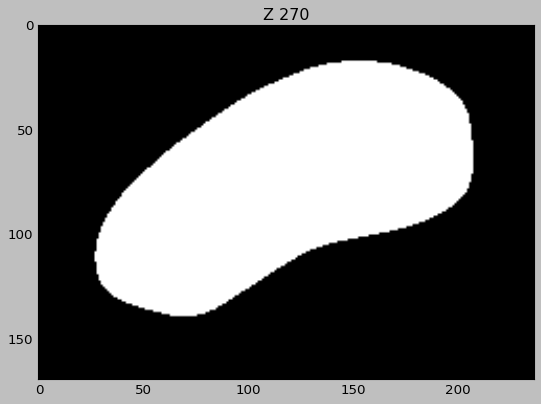

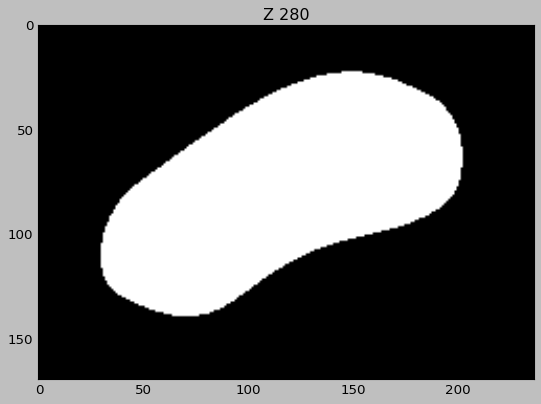

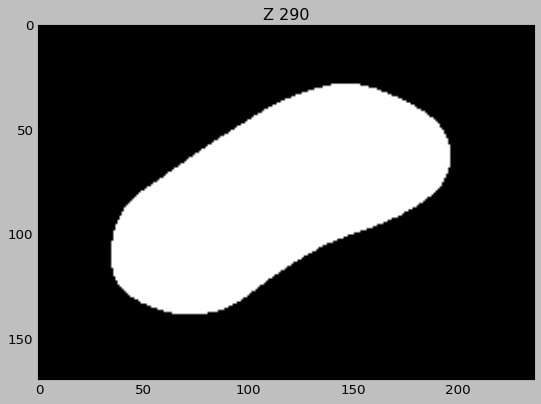

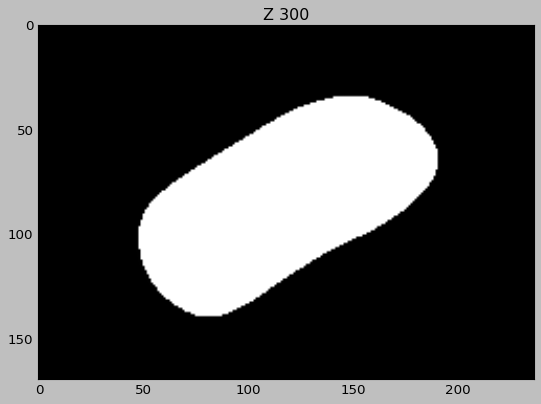

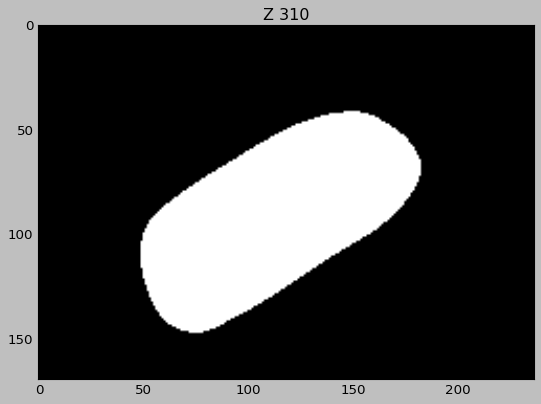

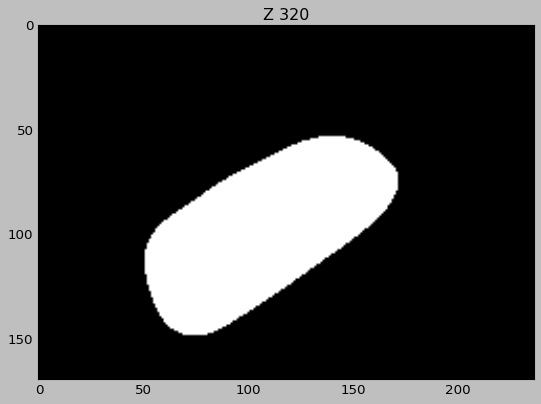

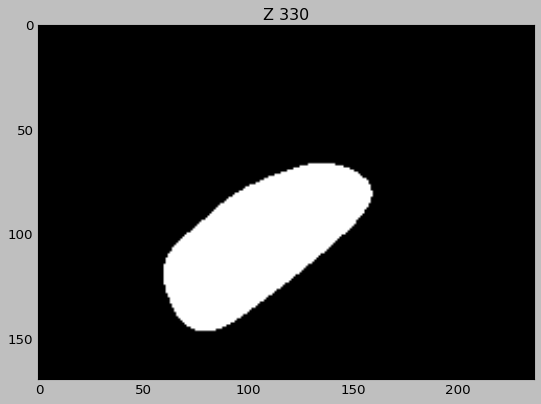

In [109]:
arr = volume
limit = 40
#start = (arr.shape[2] // 2) - limit
#end = start + limit * 2
start = limit
end = arr.shape[2] - limit
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 10):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="gray")
    plt.show()

In [5]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
csvfile = os.path.join(PATH, 'neuroglancer/contours','MD589_annotation_contours.csv')
df = pd.read_csv(csvfile)
structures_arr = df.name.unique()

In [11]:
df[['name','creator', 'section', 'vertices']].head(5)
#df.head(5)


,name,creator,section,vertices
0,VCA,yuncong,367,[[15450.64315379 13041.15143737]\n [15292.3766...
1,IO,yuncong,260,[[25199.46145603 17916.30221869]\n [24976.1090...
2,LRt,yuncong,286,[[29069.49187508 17203.67921491]\n [28909.8937...
3,LRt,yuncong,276,[[29219.12776439 16422.80664145]\n [29084.8059...
4,SC,yuncong,202,[[21584.44352233 7847.78193722]\n [21497.5691...


In [ ]:
structures = structures_arr.tolist()
type(structures)

In [ ]:
df = MD589_annotations.groupby(['creator', 'name'])

In [ ]:
df.name.unique()

In [ ]:
sc = df.loc[df['name'] == 'SC']

In [ ]:
vertices = df['vertices'][244]

In [ ]:
sc[['name', 'section','creator', 'vertices']].sort_values(by=['section'])

In [ ]:
animal = 'atlasV7'
target_structure = 'Tz'
str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)

In [ ]:
first_sec, last_sec

In [ ]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[460,460,20000])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=vm,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

In [ ]:
csvfile = os.path.join(PATH, 'neuroglancer/contours', 'hand_annotations.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
animal = 'MD589'
color_codes = {"3N": 3, "4N": 4, "5N": 5, "6N": 6, "Tz": 24, "VCA_L": 25, "VCA_R": 25, "SC":18, "IC":11}
viewer = neuroglancer.Viewer()
# Sets 'Image' layer to be MD585 prep2 images from S3
with viewer.txn() as s:
    s.layers[animal] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/'+animal+'_fullres')
    s.layout = 'xy' # '3d'/'4panel'/'xy'
print(viewer)

In [ ]:
neuroglancer.stop()

In [ ]:
structures = ['SC', 'IC']

for target_structure in structures:
    color = color_codes[target_structure]
    str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)
    ng_structure_volume, xyz_offsets = add_structure_to_neuroglancer(viewer, str_contours_annotation, target_structure, animal, first_sec, last_sec, \
                                                        color_radius=2, xy_ng_resolution_um=5, threshold=1, color=color, \
                                                        solid_volume=False, no_offset_big_volume=True, save_results=False, \
                                                        return_with_offsets=True, add_to_ng=True, human_annotation=True )


In [ ]:
print(viewer)

In [ ]:
structures = ['3N', '4N', '5N', '6N', 'Tz']
for structure, volume, offset in zip(structures, structure_volumes,offsets):
    vm = np.swapaxes(volume,0,2)
    print(structure, vm.shape, offset)